In [45]:
import pandas as pd 
import numpy as np
import glob

from pymutspec.draw import plot_mutspec192, plot_mutspec12
from pymutspec.constants import possible_sbs192, possible_sbs12
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import spatial

In [49]:
mutspecs_cytb = pd.read_csv('../data/MutSpecVertebratescytb.csv')
mutspecs_cytb.head()

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,TTT,Actinopterygii
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,GTT,Actinopterygii
2,Abbottina_obtusirostris,C[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,CTT,Actinopterygii
3,Abbottina_obtusirostris,A[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,ATT,Actinopterygii
4,Abbottina_obtusirostris,T[T>C]T,8.0,0.0,0.0,1.088889,0.0,T>C,TTT,Actinopterygii


We already have cytb so let's focus on cox1

In [51]:
cox1_mut = pd.read_csv('../data/counted_codons_cox1.csv')
cox1_mut.head()

,Unnamed: 0,Species,Gene,ExpectedObserved,A[A>G]A,A[A>G]C,A[A>G]G,A[A>G]T,A[C>T]A,A[C>T]C,...,A[G>T]A,A[G>T]G,A[G>T]T,A[T>A]A,A[T>A]C,A[T>A]G,A[T>A]T,A[T>G]A,A[T>G]G,A[T>G]T
0,0,Abbottina_rivularis,COX1,Expected,6.0,7.0,8.0,5.0,11.0,12.0,...,0,0,0,0,0,0,0,0,0,0
1,1,Abbottina_rivularis,COX1,Observed,0.0,0.0,0.0,0.0,3.0,4.0,...,0,0,0,0,0,0,0,0,0,0
2,2,Acanthogobius_hasta,COX1,Expected,2.0,7.0,8.0,3.0,16.0,14.0,...,0,0,0,0,0,0,0,0,0,0
3,3,Acanthogobius_hasta,COX1,Observed,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,4,Acipenser_schrenckii,COX1,Expected,2.0,7.0,8.0,2.0,16.0,13.0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
counted_codons_cox1 = cox1_mut.drop("Gene", axis=1)

_counted_codons_cox1 = counted_codons_cox1.melt(["Species", "ExpectedObserved"], counted_codons_cox1.columns[2:], var_name="Mut")
mutations_cox1 = _counted_codons_cox1.pivot(index=["Species", "Mut"], columns="ExpectedObserved", values="value").reset_index()
mutations_cox1["RawMutSpec"] = (mutations_cox1["Observed"] / mutations_cox1["Expected"]).fillna(0)
mutations_cox1["RawMutSpec"] = mutations_cox1["RawMutSpec"].replace(np.inf, 0)
rawsum_df_cox1 = mutations_cox1.groupby("Species").RawMutSpec.sum().reset_index().rename(columns={"RawMutSpec": "RawMutSpecSum"})
mutspecs_cox1 = pd.merge(mutations_cox1, rawsum_df_cox1, on="Species")
mutspecs_cox1["MutSpec"] = mutspecs_cox1["RawMutSpec"] / mutspecs_cox1["RawMutSpecSum"]
mutspecs_cox1.head()

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec
0,Abbottina_rivularis,A[A>C]A,0.0,0.0,0.0,30.341533,0.0
1,Abbottina_rivularis,A[A>C]C,0.0,0.0,0.0,30.341533,0.0
2,Abbottina_rivularis,A[A>C]G,0.0,0.0,0.0,30.341533,0.0
3,Abbottina_rivularis,A[A>C]T,0.0,0.0,0.0,30.341533,0.0
4,Abbottina_rivularis,A[A>G]A,6.0,0.0,0.0,30.341533,0.0


### CHANGED TO HEAVY STRAND CYTB already have it

In [53]:
def getrevers(mut):
    translator = str.maketrans("ACGT", "TGCA")
    new_mut = mut[-1] + mut[1:-1] + mut[0]
    new_mut = new_mut.translate(translator)
    return new_mut

In [54]:
mutspecs_cox1['Mut'] = mutspecs_cox1.Mut.apply(getrevers)
mutspecs_cox1["MutBase"] = mutspecs_cox1.Mut.str.slice(2, 5)
mutspecs_cox1["Context"] = mutspecs_cox1.Mut.str.get(0) + mutspecs_cox1.Mut.str.get(2) + mutspecs_cox1.Mut.str.get(-1)


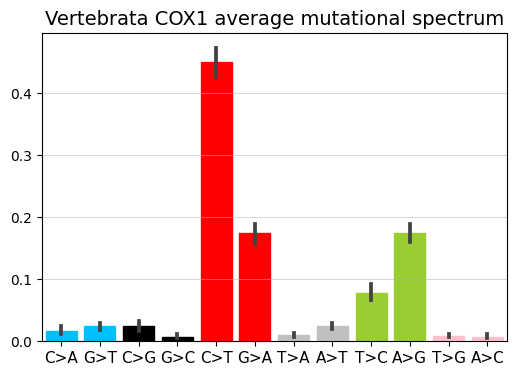

In [55]:
_species_spectra12 = mutspecs_cox1.copy()
_species_spectra12["Mut"] = _species_spectra12["Mut"].str.slice(2,5)
ax = plot_mutspec12(
    _species_spectra12.groupby(["Species", "Mut"]).MutSpec.sum().reset_index(), 
    fontname="Arial", ticksize=11, title="Vertebrata COX1 average mutational spectrum")

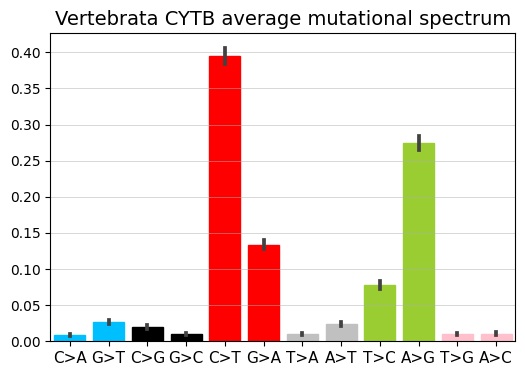

In [56]:
_species_spectra12 = mutspecs_cytb.copy()
_species_spectra12["Mut"] = _species_spectra12["Mut"].str.slice(2,5)
ax = plot_mutspec12(
    _species_spectra12.groupby(["Species", "Mut"]).MutSpec.sum().reset_index(), 
    fontname="Arial", ticksize=11, title="Vertebrata CYTB average mutational spectrum",
    )

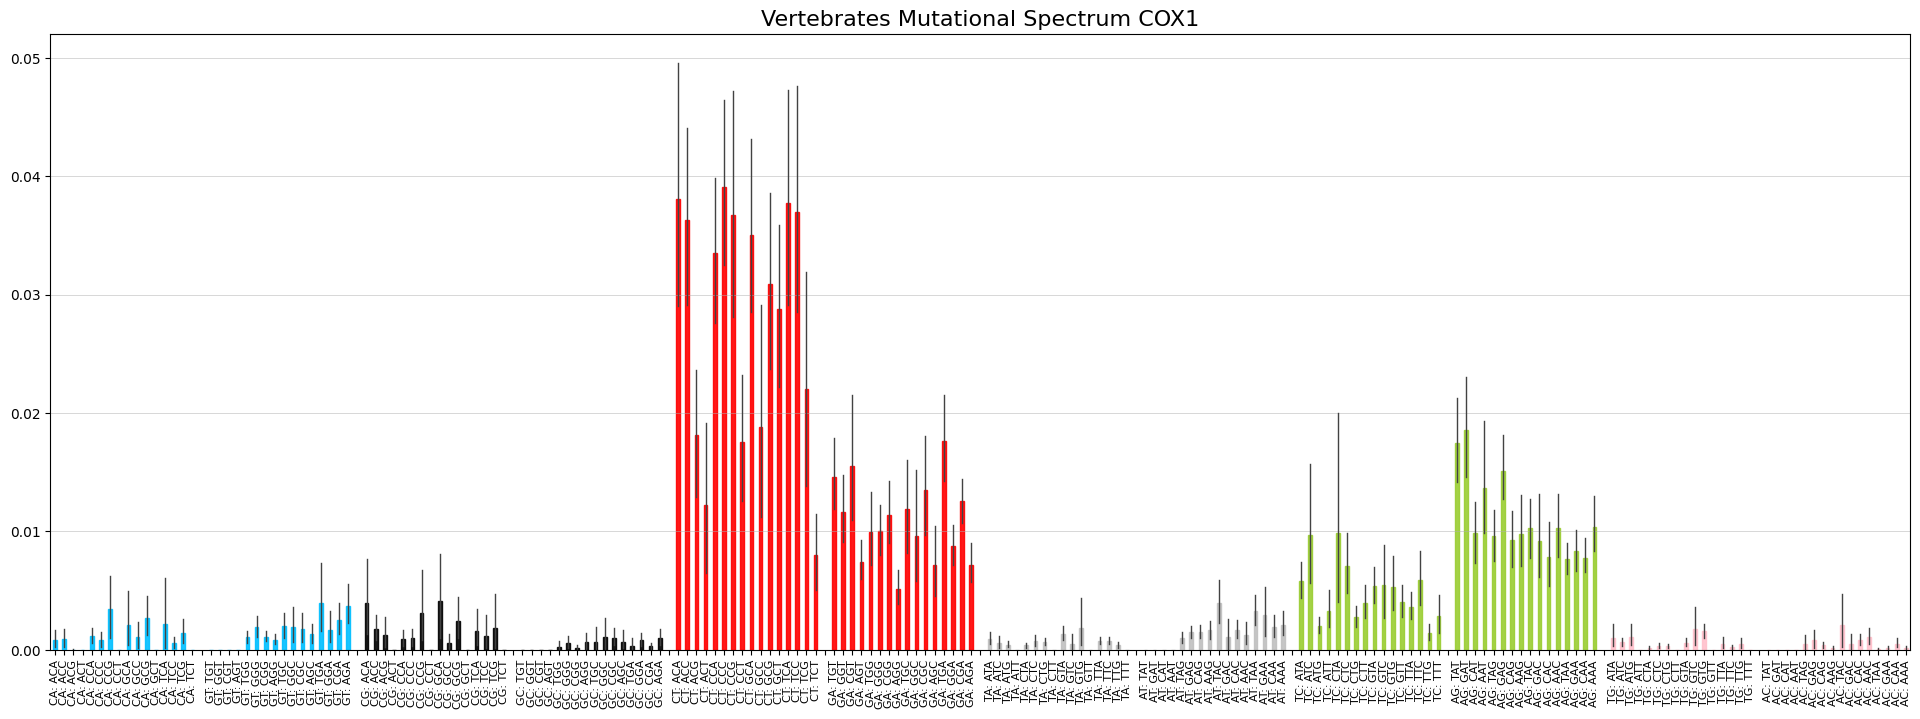

<AxesSubplot:title={'center':'Vertebrates Mutational Spectrum COX1'}>

In [57]:
plot_mutspec192(mutspecs_cox1, title='Vertebrates Mutational Spectrum COX1',
                fontname='Courier', ticksize=8, labels_style='long')

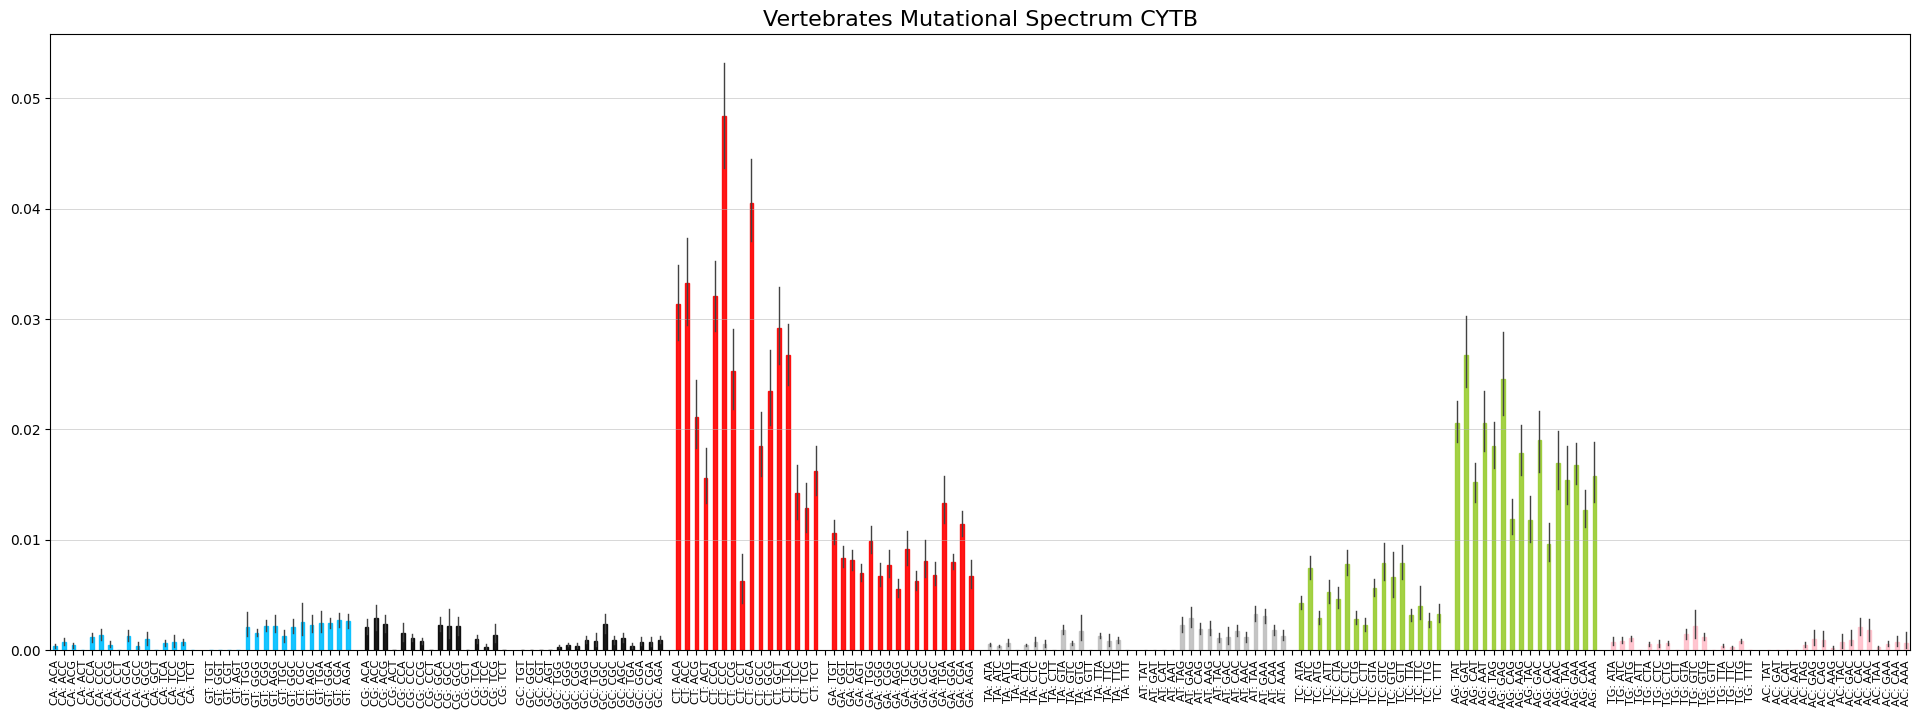

<AxesSubplot:title={'center':'Vertebrates Mutational Spectrum CYTB'}>

In [58]:
plot_mutspec192(mutspecs_cytb, title='Vertebrates Mutational Spectrum CYTB',
                fontname='Courier', ticksize=8, labels_style='long')

Calculate cosine similarity

In [59]:
ms_all_cox1 = mutspecs_cox1.groupby(['Mut'])['RawMutSpec'].sum().reset_index()
ms_all_cox1["RawMutSpecSum"] = ms_all_cox1.RawMutSpec.sum()

ms_all_cox1['MutSpec'] = ms_all_cox1.RawMutSpec / ms_all_cox1.RawMutSpecSum
ms_all_cox1 = ms_all_cox1.drop(['RawMutSpec', 'RawMutSpecSum'], axis=1)

ms_all_cox1

,Mut,MutSpec
0,A[A>C]A,0.000409
1,A[A>C]C,0.001728
2,A[A>C]G,0.000273
3,A[A>C]T,0.000000
4,A[A>G]A,0.008995
...,...,...
187,T[T>C]T,0.002409
188,T[T>G]A,0.000407
189,T[T>G]C,0.000439
190,T[T>G]G,0.000548


In [60]:
ms_all_cytb = mutspecs_cytb.groupby(['Mut'])['RawMutSpec'].sum().reset_index()
ms_all_cytb["RawMutSpecSum"] = ms_all_cytb.RawMutSpec.sum()

ms_all_cytb['MutSpec'] = ms_all_cytb.RawMutSpec / ms_all_cytb.RawMutSpecSum
ms_all_cytb = ms_all_cytb.drop(['RawMutSpec', 'RawMutSpecSum'], axis=1)

ms_all_cytb

,Mut,MutSpec
0,A[A>C]A,0.000428
1,A[A>C]C,0.001440
2,A[A>C]G,0.000192
3,A[A>C]T,0.000000
4,A[A>G]A,0.014370
...,...,...
187,T[T>C]T,0.002853
188,T[T>G]A,0.000457
189,T[T>G]C,0.000357
190,T[T>G]G,0.000874


In [61]:
print(f'Cosine similarity btw COX1 and CytB on old data is: {1 - spatial.distance.cosine(ms_all_cytb.MutSpec, ms_all_cox1.MutSpec)} \nnumber of species not the same')

Cosine similarity btw COX1 and CytB on old data is: 0.9506812086756782 
number of species not the same


# Work with BE data (BIG ONE)

get full 192 comp spectrum in main format

In [39]:
bg_full_ms = pd.read_csv('/home/kpotoh/nemu-pipeline/data/chordata2/spectra192.csv')
bg_full_ms = bg_full_ms.melt(id_vars=['gene__species'], value_vars=bg_full_ms[:-2], var_name='Mut')

bg_full_ms['Gene'] = bg_full_ms['gene__species'].apply(lambda x: x.split('__')[0])
bg_full_ms['Species'] = bg_full_ms['gene__species'].apply(lambda x: x.split('__')[1])
bg_full_ms["MutSpec"] = bg_full_ms["value"].replace(np.nan, 0)
bg_full_ms = bg_full_ms.drop(['gene__species', 'value'], axis=1)

### Change to heavy strand
bg_full_ms['Mut'] = bg_full_ms['Mut'].apply(getrevers)
bg_full_ms["MutBase"] = bg_full_ms.Mut.str.slice(2, 5)
bg_full_ms["Context"] = bg_full_ms.Mut.str.get(0) + bg_full_ms.Mut.str.get(2) + bg_full_ms.Mut.str.get(-1)

bg_full_ms.head()

,Mut,Gene,Species,MutSpec,MutBase,Context
0,T[T>G]T,A6,Acanthurus_triostegus,0.0,T>G,TTT
1,T[T>G]T,A6,Adelomyia_melanogenys,0.0,T>G,TTT
2,T[T>G]T,A6,Agkistrodon_contortrix,0.0,T>G,TTT
3,T[T>G]T,A6,Agkistrodon_piscivorus,0.0,T>G,TTT
4,T[T>G]T,A6,Alethe_diademata,0.0,T>G,TTT


plot 192 comp spectra for COX1 and CytB

findfont: Font family ['Courier'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Courier'] not found. Falling back to DejaVu Sans.


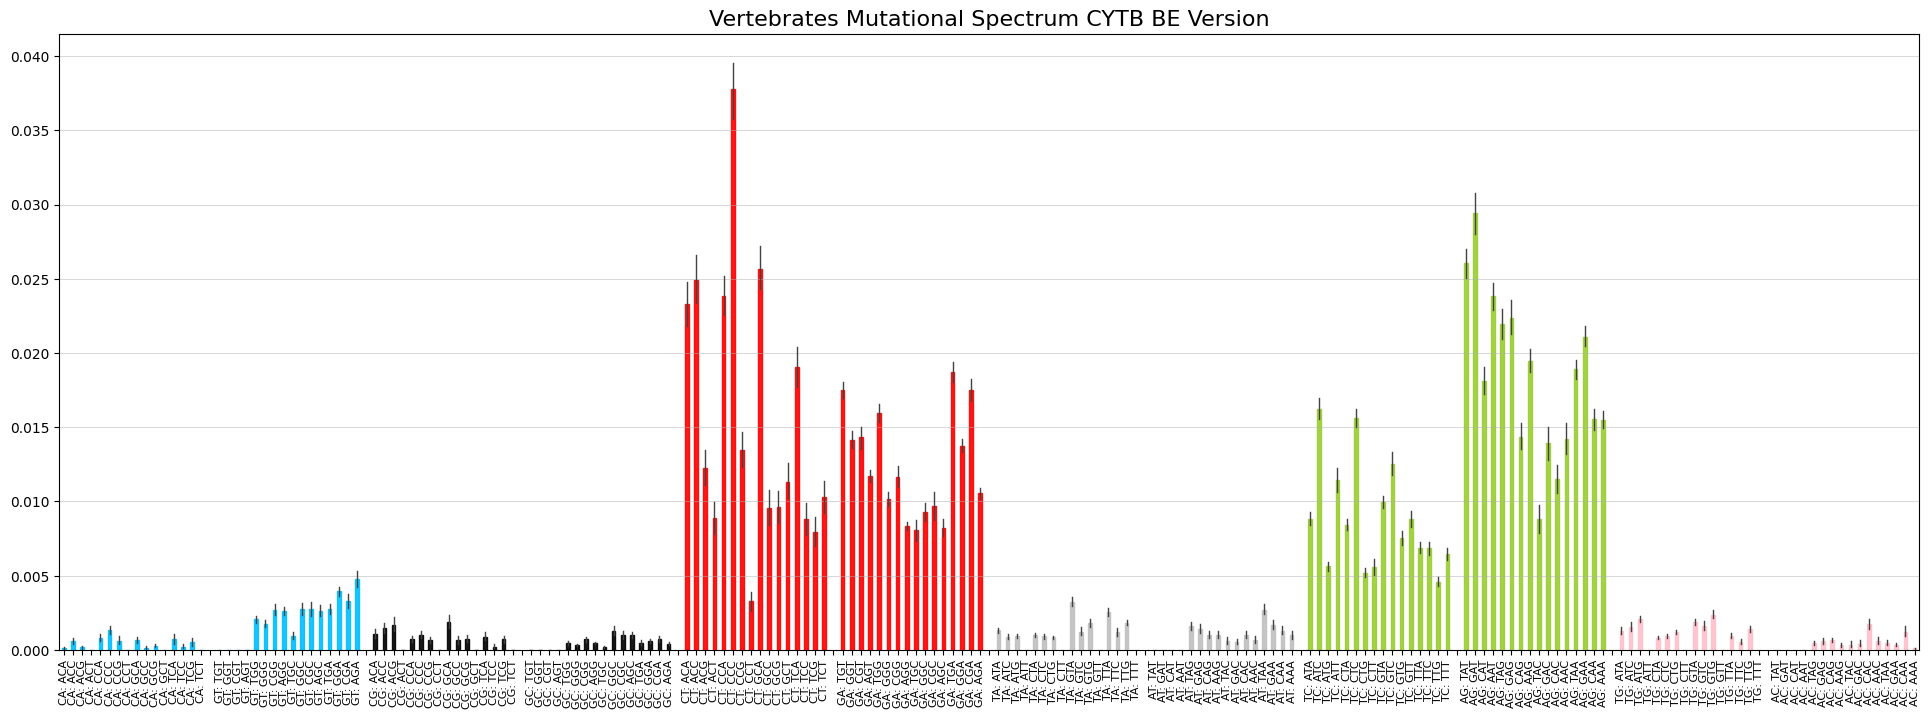

<AxesSubplot:title={'center':'Vertebrates Mutational Spectrum CYTB BE Version'}>

In [40]:
plot_mutspec192(bg_full_ms[bg_full_ms.Gene == 'Cytb'], title='Vertebrates Mutational Spectrum CYTB BE Version',
                fontname='Courier', ticksize=8, labels_style='long')

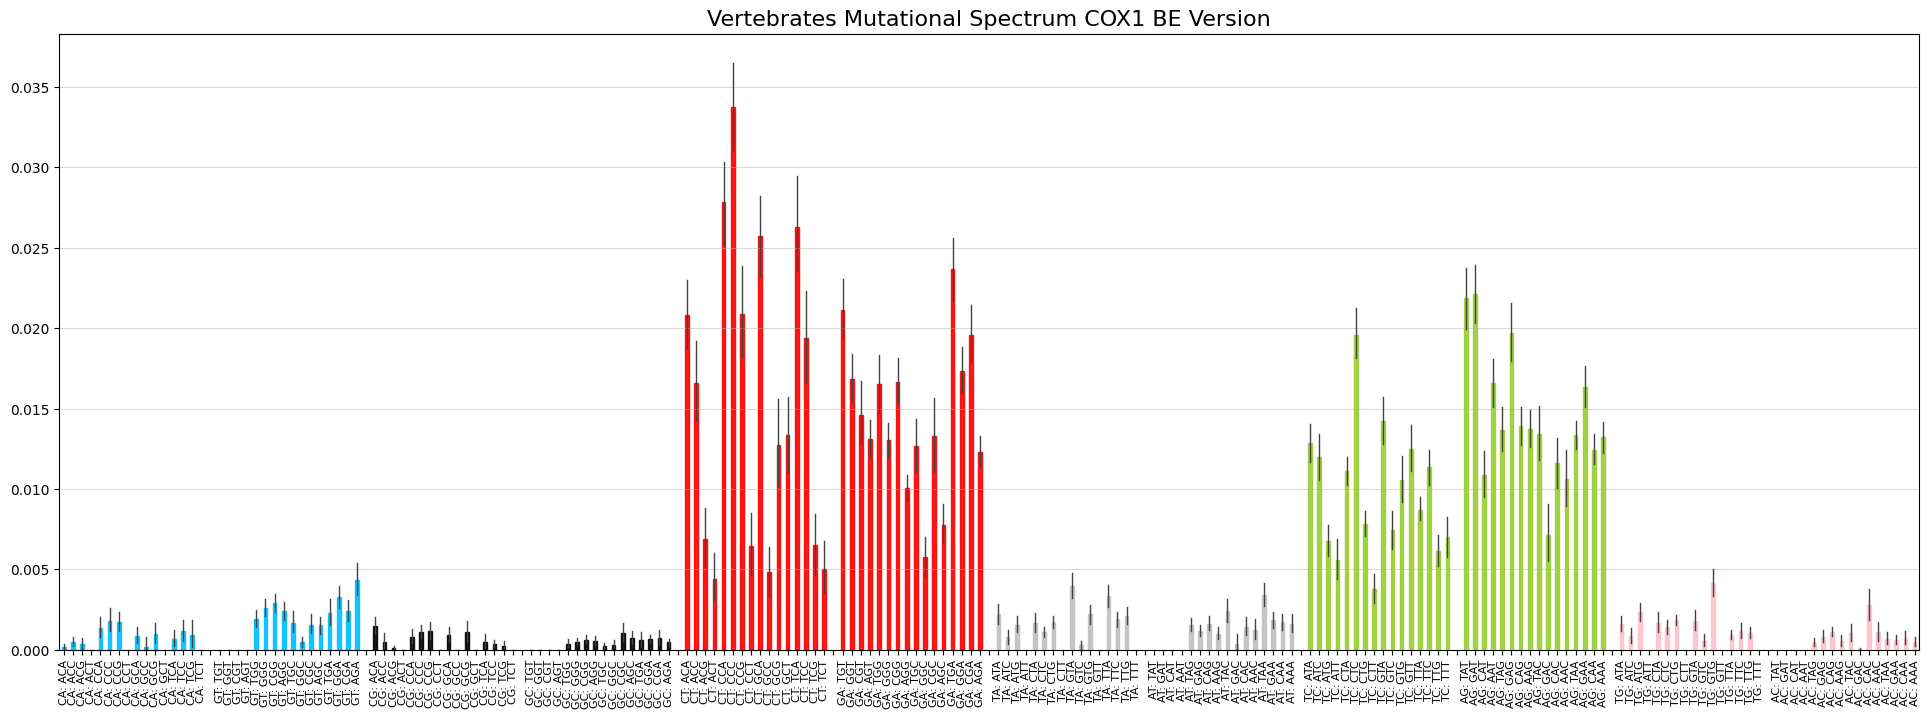

<AxesSubplot:title={'center':'Vertebrates Mutational Spectrum COX1 BE Version'}>

In [41]:
plot_mutspec192(bg_full_ms[bg_full_ms.Gene == 'CO1'], title='Vertebrates Mutational Spectrum COX1 BE Version',
                fontname='Courier', ticksize=8, labels_style='long')

get 12 comp spectra for both COX 1 and CYTB

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


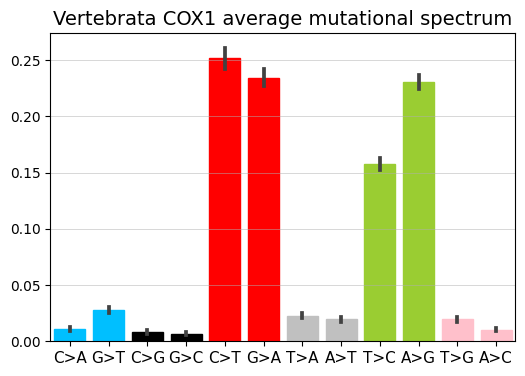

In [42]:
_species_spectra12 = bg_full_ms[bg_full_ms.Gene == 'CO1'].copy()
_species_spectra12["Mut"] = _species_spectra12["Mut"].str.slice(2,5)
ax = plot_mutspec12(
    _species_spectra12.groupby(["Species", "Mut"]).MutSpec.sum().reset_index(), 
    fontname="Arial", ticksize=11, title="Vertebrata COX1 average mutational spectrum",
    )

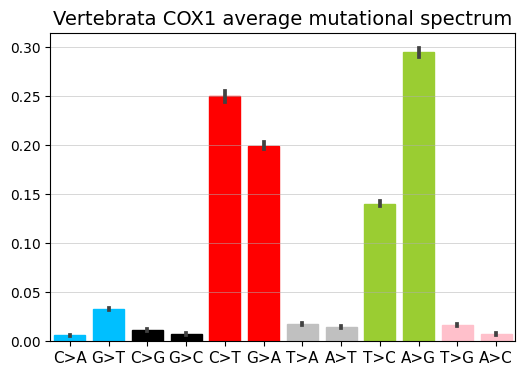

In [43]:
_species_spectra12 = bg_full_ms[bg_full_ms.Gene == 'Cytb'].copy()
_species_spectra12["Mut"] = _species_spectra12["Mut"].str.slice(2,5)
ax = plot_mutspec12(
    _species_spectra12.groupby(["Species", "Mut"]).MutSpec.sum().reset_index(), 
    fontname="Arial", ticksize=11, title="Vertebrata COX1 average mutational spectrum",
    )